(7, 101)
(4, 101)
(4, 101)


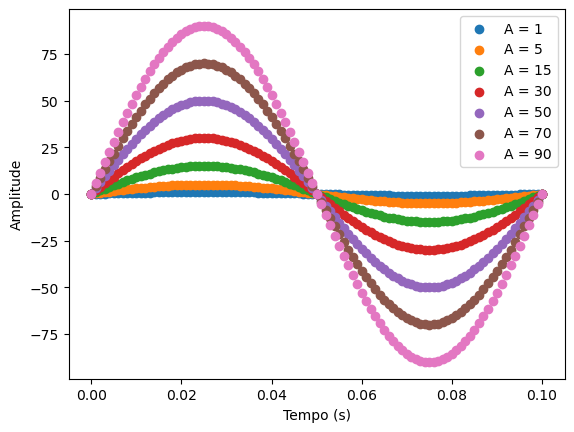

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def get_signal(f0,t,amplitude, noise=False, noise_std = 0.3):
    if noise == True:
        return amplitude*np.sin(2*np.pi*f0*t) + np.random.uniform(noise_std*amplitude, -noise_std*amplitude, len(t))
        
    return amplitude*np.sin(2*np.pi*f0*t)

def make_set(amplitudes, frequence, time):
    flag = False
    target = []
    features = []
    noise_list = [0.3,0.4,0.5]
    for a in amplitudes:
        signal_pure = get_signal(frequence, time, a)
        signal_noise = get_signal(frequence, time, a, True, noise_list[np.random.randint(0,len(noise_list)-1)])

        if flag == False:
            features = signal_pure.reshape(1,-1)
            target = signal_pure.reshape(1, -1)
            flag = True
        else:
            target = np.concatenate((target, signal_pure.reshape(1,-1)), axis=0)
            features = np.concatenate((features, signal_pure.reshape(1,-1)), axis=0)
    return (features, target)

f0 = 10 #frequencia do sinal hz
periodo = 1/f0 #intervalo de amostragem
N_amostras = 100
ts = periodo / N_amostras
time = np.arange(0, periodo + ts, ts)

train_set_amplitudes = [1,5,15,30,50,70,90]
train_set, train_target = make_set(train_set_amplitudes, f0, time)
validation_set_amplitudes = [10,20,60,80]
validation_set, validation_target = make_set(validation_set_amplitudes, f0, time)
test_set_amplitudes = [12,40,75,100]
test_set, test_target = make_set([12,40,75,100], f0, time)

for i, a in enumerate(train_set_amplitudes):
    plt.scatter(time, train_set[i,:], label = f"A = {a}")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.legend()
print (train_set.shape)
print (validation_set.shape)
print (test_set.shape)

In [100]:
from sklearn import preprocessing as pre

input_data_scaler = pre.MinMaxScaler()
target_scaler = pre.MinMaxScaler()
train_set_scaled = input_data_scaler.fit_transform(train_set)
train_target_scaled = target_scaler.fit_transform(train_target)

validation_set_scaled = input_data_scaler.transform(validation_set)
validation_target_scaled = target_scaler.transform(validation_target)

In [101]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow_addons.metrics import RSquare
tf.keras.utils.set_random_seed(0)

neurons_std_amount = train_set_scaled.shape[1]

model = Sequential()
model.add(tf.keras.Input(neurons_std_amount))
model.add(Dense(neurons_std_amount, activation=tf.keras.activations.swish, name="Encoder"))
model.add(Dense(1, activation=tf.keras.activations.swish, name="Latent-Space"))
model.add(Dense(neurons_std_amount, activation=tf.keras.activations.swish, name="Decoder"))
model.add(Dense(neurons_std_amount, activation=tf.keras.activations.swish, name="Output"))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[RSquare()])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Dense)             (None, 101)               10302     
                                                                 
 Latent-Space (Dense)        (None, 1)                 102       
                                                                 
 Decoder (Dense)             (None, 101)               202       
                                                                 
 Output (Dense)              (None, 101)               10302     
                                                                 
Total params: 20,908
Trainable params: 20,908
Non-trainable params: 0
_________________________________________________________________


In [102]:
model.fit(train_set_scaled, train_target_scaled, validation_data=(validation_set_scaled, validation_target_scaled), epochs=430)

Epoch 1/430
1/1 [==============================] - 2s 2s/step - loss: 0.3797 - r_square: -2.0524 - val_loss: 0.3502 - val_r_square: -2.3975
Epoch 2/430
1/1 [==============================] - 0s 37ms/step - loss: 0.3786 - r_square: -2.0440 - val_loss: 0.3491 - val_r_square: -2.3873
Epoch 3/430
1/1 [==============================] - 0s 37ms/step - loss: 0.3775 - r_square: -2.0347 - val_loss: 0.3480 - val_r_square: -2.3765
Epoch 4/430
1/1 [==============================] - 0s 34ms/step - loss: 0.3763 - r_square: -2.0251 - val_loss: 0.3469 - val_r_square: -2.3657
Epoch 5/430
1/1 [==============================] - 0s 36ms/step - loss: 0.3751 - r_square: -2.0155 - val_loss: 0.3457 - val_r_square: -2.3548
Epoch 6/430
1/1 [==============================] - 0s 33ms/step - loss: 0.3739 - r_square: -2.0058 - val_loss: 0.3445 - val_r_square: -2.3432
Epoch 7/430
1/1 [==============================] - 0s 32ms/step - loss: 0.3726 - r_square: -1.9953 - val_loss: 0.3432 - val_r_square: -2.3304
Epoch 8/

In [103]:
import pathlib
import os
import time

CURRENT_FILE_LOCATION = pathlib.Path(os.getcwd())
PATH_SAVED = CURRENT_FILE_LOCATION / "saved_models" / str(time.time())

model.save(PATH_SAVED)

INFO:tensorflow:Assets written to: c:\Users\leonardo\Documents\mestrado\ML\AutoEncoders\saved_models\1682960888.490098\assets


c:\Users\leonardo\Documents\mestrado\ML\AutoEncoders\saved_models\1682960888.490098
1/1 [==============================] - 0s 123ms/step


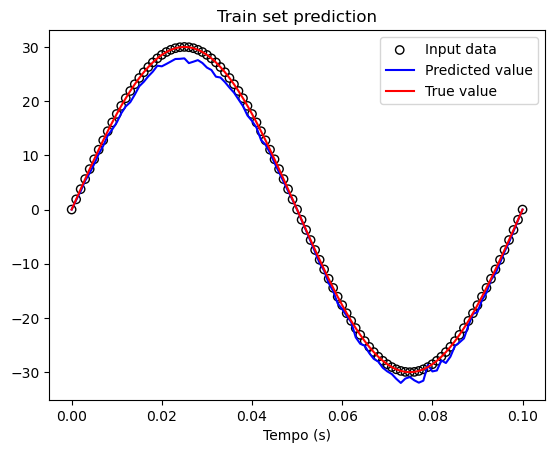

In [104]:
import tensorflow as tf

print (PATH_SAVED)
f0 = 10 #frequencia do sinal hz
periodo = 1/f0 #intervalo de amostragem
N_amostras = 100
ts = periodo / N_amostras
time = np.arange(0, periodo + ts, ts)

model = tf.keras.models.load_model(PATH_SAVED)

signal_row = 3
sinal_predito_scaled = model.predict(train_set_scaled)


input_data = input_data_scaler.inverse_transform(train_set_scaled)
target = target_scaler.inverse_transform(train_target_scaled)
sinal_predito = target_scaler.inverse_transform(sinal_predito_scaled)

plt.scatter(time, input_data[signal_row,:], label="Input data", facecolors='none', edgecolors='k')
plt.xlabel("Tempo (s)")
plt.plot(time, sinal_predito[signal_row, :], label="Predicted value", color='blue')
plt.plot(time, target[signal_row, :], label="True value", color='red')
plt.legend()
plt.title("Train set prediction")
plt.show()

In [105]:
signal_row = 3
sinal_predito_scaled = model.predict(validation_set_scaled)


input_data = input_data_scaler.inverse_transform(validation_set_scaled)
target = target_scaler.inverse_transform(validation_target_scaled)
sinal_predito = target_scaler.inverse_transform(sinal_predito_scaled)

plt.scatter(time, input_data[signal_row,:], label="Input data", facecolors='none', edgecolors='k')
plt.xlabel("Tempo (s)")
plt.plot(time, sinal_predito[signal_row, :], label="Predicted value", color='blue')
plt.plot(time, target[signal_row, :], label="True value", color='red')
plt.legend()
plt.title("Validation set prediction")
plt.show()

1/1 [==============================] - 0s 18ms/step


In [106]:
from sklearn.metrics import r2_score

signal_row = 3
test_set_scaled = input_data_scaler.transform(test_set)
test_target_scaled = target_scaler.transform(test_target)

sinal_predito_scaled = model.predict(test_set_scaled)

score = r2_score(sinal_predito_scaled, test_target_scaled)

print (f"Test set Rsquare score = {score}")

input_data = input_data_scaler.inverse_transform(test_set_scaled)
target = target_scaler.inverse_transform(test_target_scaled)
sinal_predito = target_scaler.inverse_transform(sinal_predito_scaled)

plt.scatter(time, input_data[signal_row,:], label="Input data", facecolors='none', edgecolors='k')
plt.xlabel("Tempo (s)")
plt.plot(time, sinal_predito[signal_row, :], label="Predicted value", color='blue')
plt.plot(time, target[signal_row, :], label="True value", color='red')
plt.legend()
plt.title("Test set prediction")
plt.show()

1/1 [==============================] - 0s 18ms/step
Test set Rsquare score = 0.541765039866395


1/1 [==============================] - 0s 22ms/step


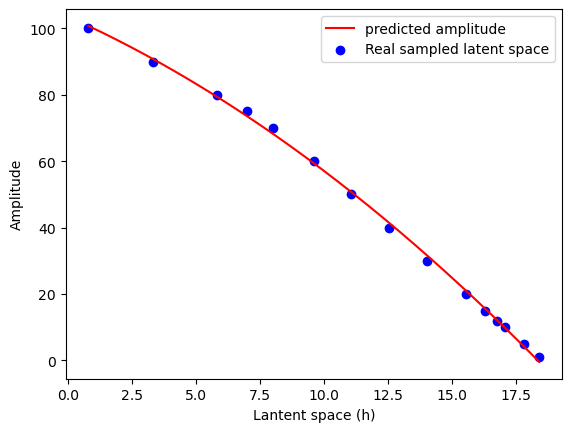

In [107]:
model = tf.keras.models.load_model(PATH_SAVED)

encoder = tf.keras.Model(
                    inputs=model.input,
                    outputs=model.get_layer("Latent-Space").output
                    )

train_set_h = encoder.predict(train_set_scaled)
validation_set_h = encoder.predict(validation_set_scaled)
test_set_h = encoder.predict(test_set_scaled)

train_set_h_a = np.concatenate((train_set_h, np.array(train_set_amplitudes).reshape(-1,1)), axis=1)
validation_set_h_a = np.concatenate((validation_set_h, np.array(validation_set_amplitudes).reshape(-1,1)), axis=1)
test_set_h_a = np.concatenate((test_set_h, np.array(test_set_amplitudes).reshape(-1,1)), axis=1)

latent_space_h_per_a = np.concatenate((train_set_h_a, validation_set_h_a, test_set_h_a), axis=0)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_poly = poly_reg.fit_transform(np.reshape(latent_space_h_per_a[:,0],(-1,1)))

regressor = LinearRegression()
regressor.fit(X_poly, latent_space_h_per_a[:,1].reshape(-1,1))

h_domain = np.arange(latent_space_h_per_a[:,0].min(), latent_space_h_per_a[:,0].max(), 0.05)
amplitudes_per_h_predicted = regressor.predict(poly_reg.fit_transform(h_domain.reshape(-1,1)))

plt.plot(h_domain, amplitudes_per_h_predicted, color = "red", label = "predicted amplitude")
plt.xlabel("Lantent space (h)")
plt.ylabel("Amplitude")
plt.scatter(latent_space_h_per_a[:,0], latent_space_h_per_a[:,1], label = "Real sampled latent space", color="blue")
plt.legend()

1/1 [==============================] - 0s 105ms/step


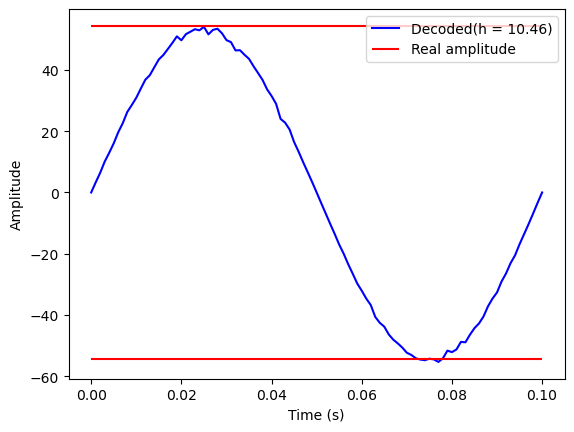

In [108]:
model = tf.keras.models.load_model(PATH_SAVED)

decoder = tf.keras.Model(
                    inputs=model.get_layer("Latent-Space").output,
                    outputs=model.get_layer("Output").output
                    )

h_space_to_predict = np.random.uniform(h_domain.min(), h_domain.max())
predicted_amplituded = regressor.predict(poly_reg.fit_transform([[h_space_to_predict]]))

scaled_prediction = decoder.predict([h_space_to_predict])
prediction = target_scaler.inverse_transform(scaled_prediction)

h_show = round(h_space_to_predict,2)
plt.plot(time, prediction[0,:], color = "blue", label = f"Decoded(h = {h_show})")
plt.hlines(predicted_amplituded, time.min(), time.max(), color = "red", label = "Real amplitude")
plt.hlines(-1*predicted_amplituded, time.min(), time.max(), color = "red")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()